In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import poisson
import ast, pickle

from Class_utils.parameters import *
from Class_utils.FitnessClasses import FitnessAge,FitnessExperience, FitnessCity
from Generator.MatchingScore import MatchingScore

from sklearn.cluster import KMeans


import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
%reload_ext autoreload
%autoreload 2

# Distributions

In [19]:
dt_language = pd.read_csv(file_paths["languages_path"],index_col=0)
dt_language.sort_values("Prob",ascending=False,inplace=True)

df_language_level = pd.read_csv(file_paths["languages_level_path"],index_col=0) # dataframe with language levels
df_language_level = df_language_level.merge(dt_language, left_index=True, right_index=True)
df_language_level.sort_values(by="Prob",ascending=False).drop("Prob",axis=1,inplace=True)
 
poisson_dist = pd.DataFrame([poisson(lam=2) for _ in range(60000)], columns=["Values"])
opt_lang_dist = pd.DataFrame(file_paths["opt_lang_distribution"], columns=["Dist"])

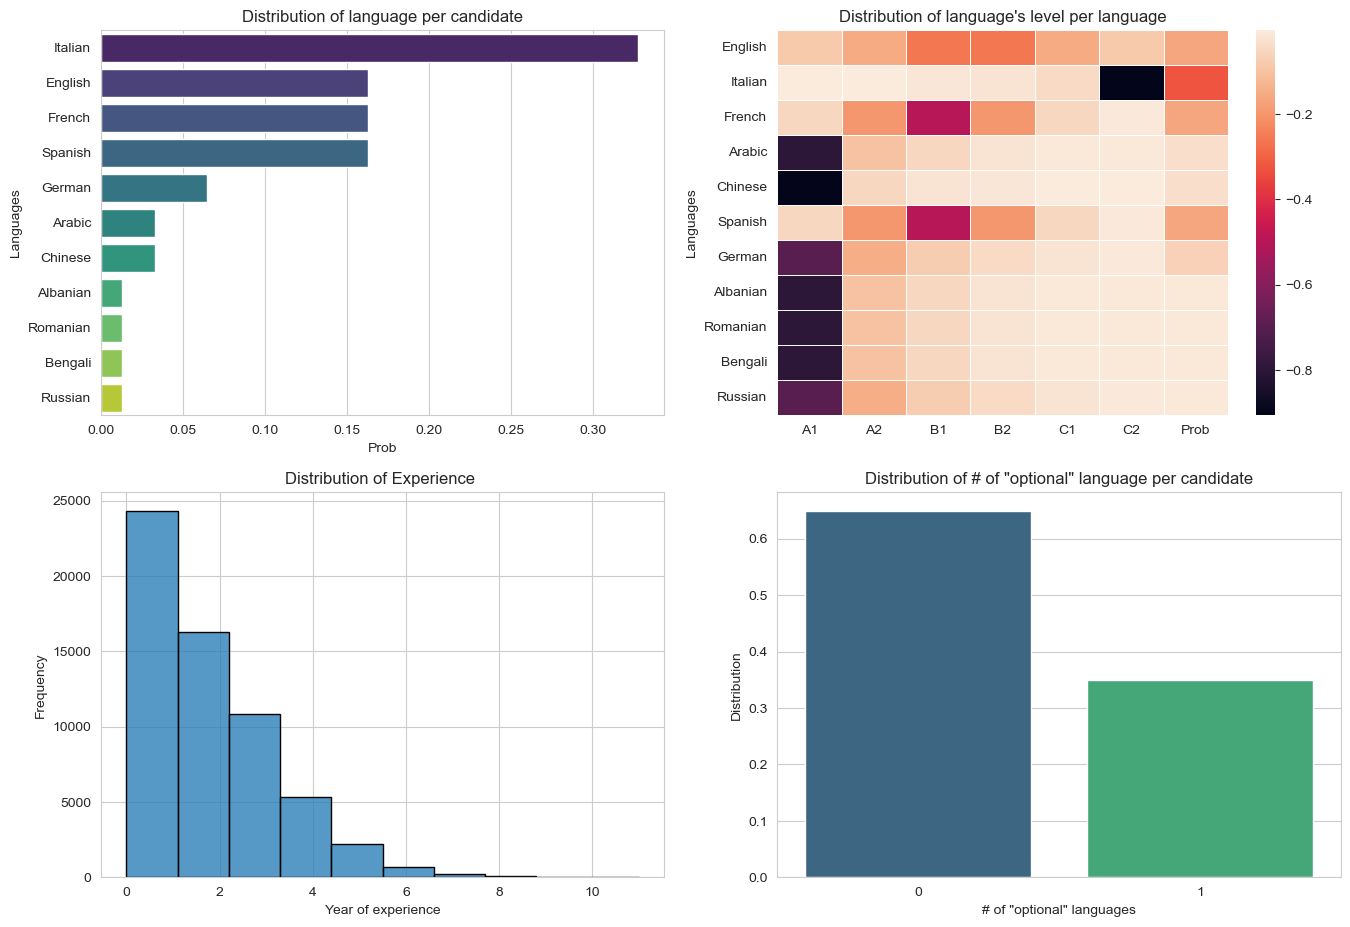

In [20]:
f, axs = plt.subplots(ncols=2,nrows=2,figsize=(16,11))

sns.barplot(x=dt_language["Prob"], y=dt_language.index, data=dt_language, palette='viridis', ax=axs[0,0])
axs[0,0].set_title('Distribution of language per candidate')

sns.heatmap(-df_language_level, linewidths=.5, ax=axs[0,1])
axs[0,1].set_title('Distribution of language\'s level per language')

sns.histplot(poisson_dist["Values"], bins=10, edgecolor='black', ax=axs[1,0])
axs[1,0].set_title('Distribution of Experience ')
axs[1,0].set_xlabel('Year of experience')
axs[1,0].set_ylabel('Frequency')


sns.barplot(y=opt_lang_dist["Dist"], x=opt_lang_dist.index, data=opt_lang_dist, palette='viridis', ax=axs[1,1])
axs[1,1].set_title('Distribution of # of "optional" language per candidate')
axs[1,1].set_xlabel('# of "optional" languages')
axs[1,1].set_ylabel('Distribution')

plt.show()

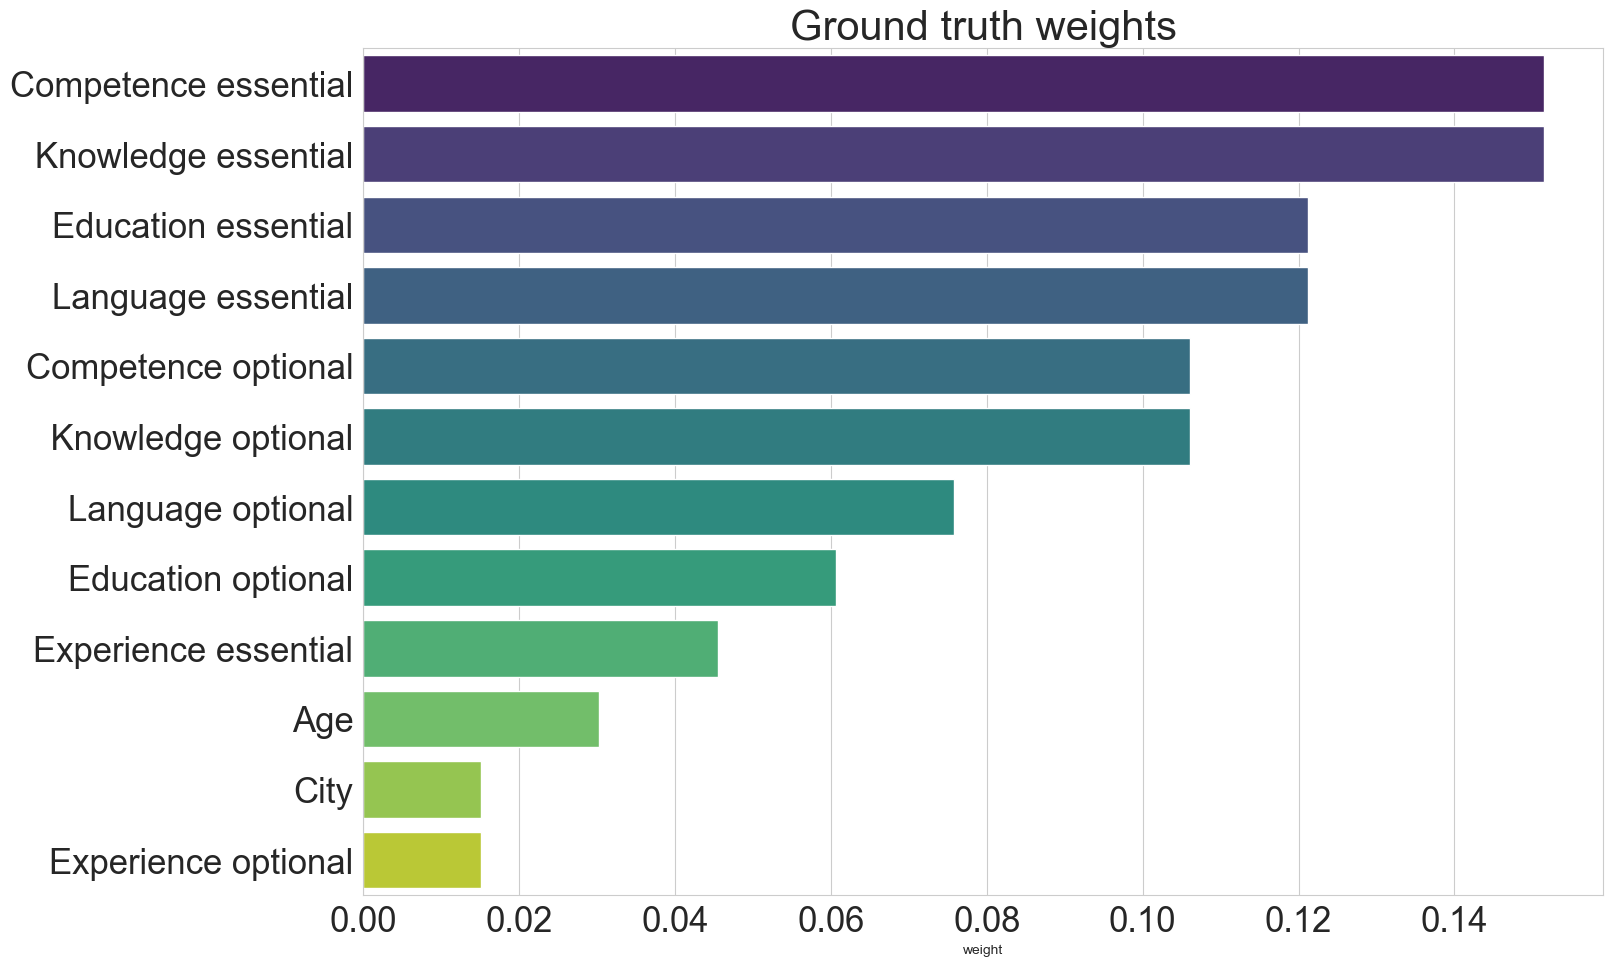

In [21]:
n_weights = MatchingScore.normalize_weights(matching_par["weight"])
features = ["Education essential","Education optional","City","Age","Experience essential","Experience optional","Language essential","Language optional", "Competence essential","Competence optional","Knowledge essential"," Knowledge optional"]
ground_truth = pd.DataFrame(n_weights,index=features,columns=["weight"]).sort_values(by="weight",ascending=False)

_, axs = plt.subplots(figsize=(16,11))
sns.barplot(x=ground_truth["weight"], y=ground_truth.index, data=ground_truth, palette='viridis', ax=axs)
axs.set_title("Ground truth weights", fontsize=30)
axs.tick_params(axis='both', labelsize=25)

plt.show()

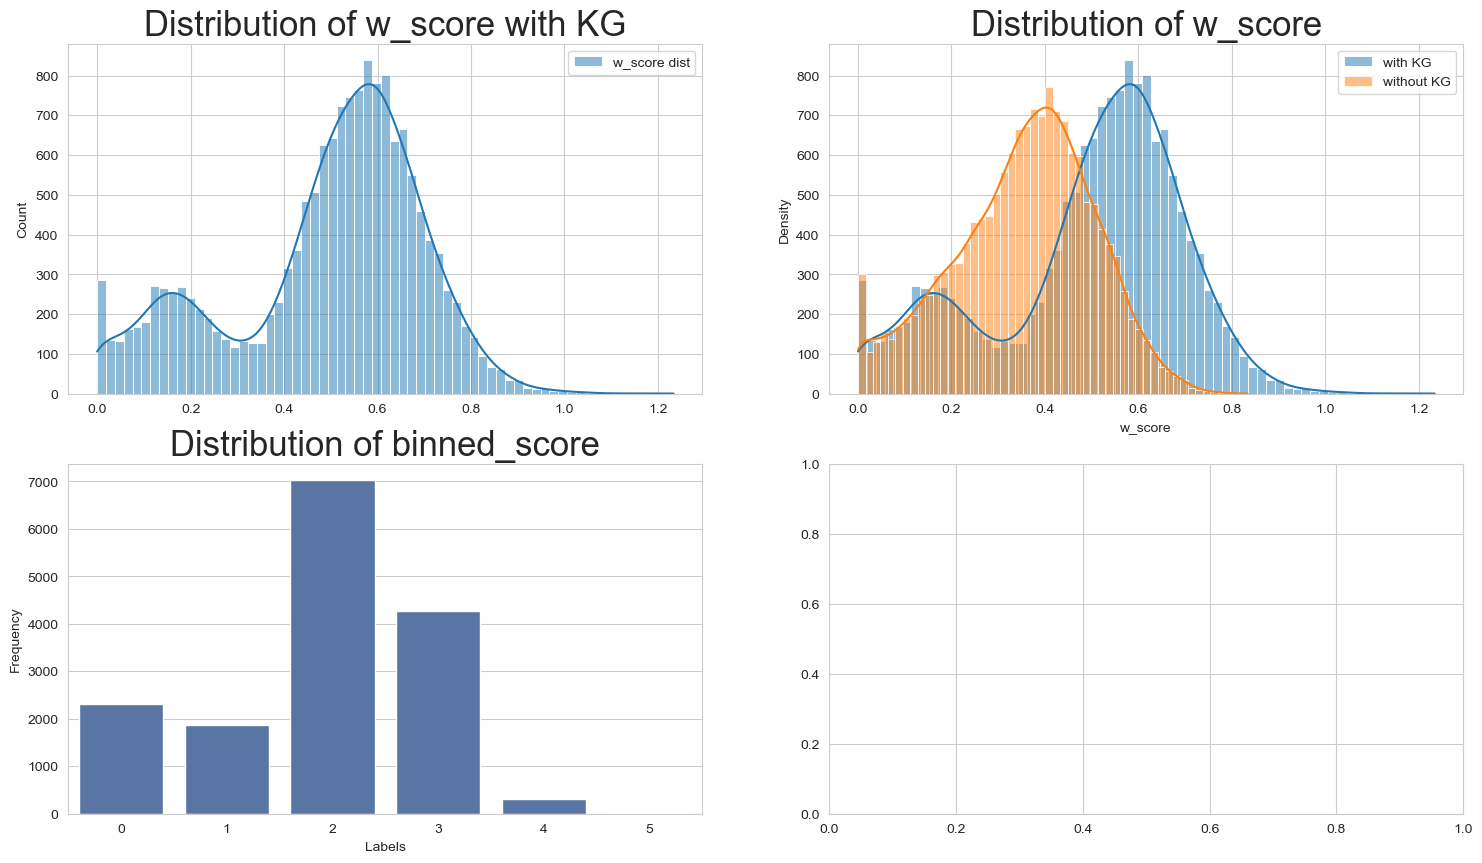

In [22]:
_, axs = plt.subplots(ncols=2,nrows=2, figsize=(18, 10))

w_score,binned_score = [],[]
for r in range(2):
    score_dt = pd.read_csv(f"../outputs/scores/{r}_dataset.csv")
    w_score.append(score_dt["w_score"].tolist())
    binned_score_ = score_dt["binned_score"].to_list()
    distri_labels = [binned_score_.count(i) for i in range(max(binned_score_)+1)]
    name_label = [*range(max(binned_score_)+1)]
    distri_labels = pd.DataFrame(distri_labels,index=name_label,columns=["Count"])
    binned_score.append(distri_labels)
    
sns.histplot(w_score[0], kde=True, label='w_score dist', ax=axs[0,0])
axs[0,0].set_title('Distribution of w_score with KG', fontsize=25)
axs[0,0].legend() 
    
sns.histplot(w_score[0], kde=True, label='with KG', ax=axs[0,1])
sns.histplot(w_score[1], kde=True, label='without KG', ax=axs[0,1])
axs[0,1].set_title('Distribution of w_score', fontsize=25)
axs[0,1].set_xlabel('w_score')
axs[0,1].set_ylabel('Density')
axs[0,1].legend()

sns.barplot(x=binned_score[0].index,y=binned_score[0]["Count"],data=binned_score[0],
            color="#4C72B0",ax=axs[1,0])

axs[1,0].set_title('Distribution of binned_score', fontsize=25)
axs[1,0].set_xlabel('Labels')
axs[1,0].set_ylabel('Frequency')

# sns.barplot(x=binned_score[0].index, y=binned_score[0]["Count"], data=binned_score[0],
#             color="#4C72B0", alpha=0.5, ax=axs[1,1], label='with KG')
# 
# sns.barplot(x=binned_score[1].index, y=binned_score[1]["Count"], data=binned_score[1],
#             color="#DD8434", alpha=0.5, ax=axs[1,1], label='without KG')
# 
# axs[1,1].legend(ncol=2, frameon=True)
# axs[1,1].set_title('Distribution of binned_score')
# axs[1,1].set_xlabel('Labels')
# axs[1,1].set_ylabel('Frequency')
plt.show()

# Fitness functions

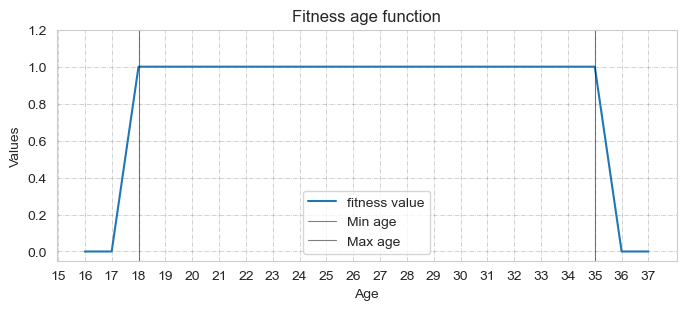

In [23]:
min_age, max_age = 18, 35
ages = [*range(16,37+1)]
age_score = [FitnessAge.fitness_basic(i,min_age,max_age) for i in ages]

_, axs = plt.subplots(figsize=(8,3))

sns.lineplot(x=ages,y=age_score, label="fitness value",ax=axs)
axs.axvline(min_age, alpha=0.5,linewidth=0.8, color="black", label="Min age")
axs.axvline(max_age, alpha=0.5,linewidth=0.8, color="black", label="Max age")
axs.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs.set_ylim(-0.05,1.2)
axs.set_xticks(np.arange(15, 37 + 1, 1))
axs.set_title("Fitness age function")
axs.set_xlabel('Age')
axs.set_ylabel('Values')
axs.legend()
plt.show()

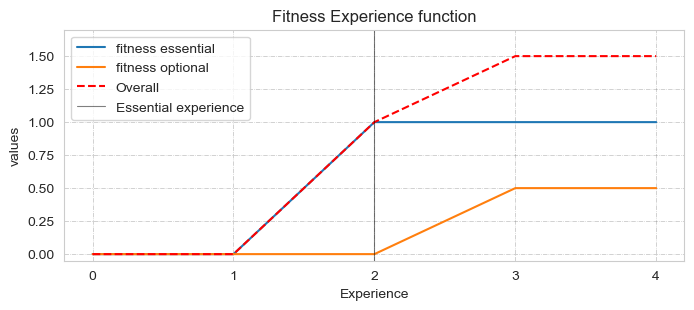

In [24]:
exp_essential,exp_optional = 2, True
experience = [*range(0,5)]

basic_score, bonus_score = [], []
for i in experience:
    a = FitnessExperience.fitness_basic(exp_essential,i)
    b = FitnessExperience.fitness_bonus(exp_essential, exp_optional, i)
    basic_score.append(a)
    bonus_score.append(b)

overall = [a + b for a,b in zip(basic_score,bonus_score)]
_, axs = plt.subplots(figsize=(8,3))

sns.lineplot(x=experience, y=basic_score, label="fitness essential")
sns.lineplot(x=experience, y=bonus_score, label="fitness optional")
sns.lineplot(x=experience, y=overall, color="red", linestyle="--", label="Overall")
axs.axvline(exp_essential, alpha=0.5,linewidth=0.8, color="black", label="Essential experience")
axs.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs.set_ylim(-0.05,1.7)
axs.set_xticks(np.arange(0,5,1))
axs.set_title("Fitness Experience function")
axs.set_xlabel('Experience')
axs.set_ylabel('values')
axs.legend()
plt.show()

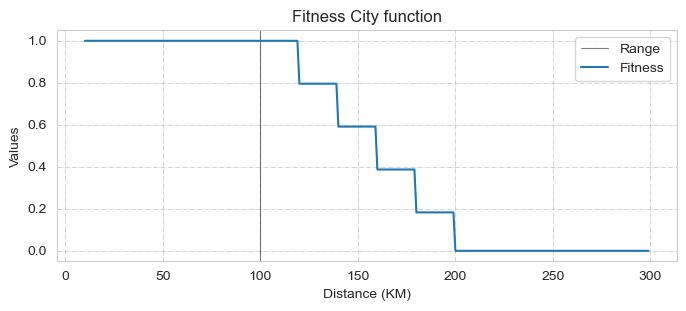

In [25]:
fitness_city = FitnessCity("../sources/cities_distance.csv")

range_ = 100
distances = [*range(10,300,1)]
fitness = [fitness_city.distance_scoring(d, range_) for d in distances]

_, axs = plt.subplots(figsize=(8,3))

axs.axvline(range_, alpha=0.5,linewidth=0.8, color="black", label="Range")
sns.lineplot(x=distances,y=fitness, label="Fitness")
axs.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs.set_title("Fitness City function")
axs.set_xlabel('Distance (KM)')
axs.set_ylabel('Values')
axs.set_ylim(-0.05,1.05)

axs.legend()
plt.show()

# Consistent curricula

In [26]:
curricula = pd.read_csv("../outputs/0_curricula.csv",usecols=[0,1,2]).set_index("kId")
vl_set = pd.read_csv("../outputs/scores/0_dataset_vl.csv").set_index("kId")

In [27]:
with open("../Models/GlassBox/figs/saved_models/FIGSReg.pkl", 'rb') as file:
    model_figs = pickle.load(file)
with open("../Models/GlassBox/ebm/saved_models/EBMReg.pkl", 'rb') as file:
    model_ebm = pickle.load(file)
with open("../Models/BlackBox/lmart/saved_models/LGBMRanker.pkl", 'rb') as file:
    model_lgbm = pickle.load(file)

In [28]:
df_normalized  = pd.json_normalize(curricula['metadata'].apply(ast.literal_eval))
curricula = pd.concat([curricula, df_normalized], axis=1)["consistent"]
curricula.index.rename("kId",inplace=True)

curricula = vl_set.merge(curricula, on="kId")[["w_score","consistent"]]
curricula['consistent'] = curricula['consistent'].apply(lambda x: "consistent" if x else "random" )

lambda_figs = model_figs.predict(vl_set.iloc[:,4:].to_numpy())
lambda_ebm = model_ebm.predict(vl_set.iloc[:,4:].to_numpy())
lambda_lgbm = model_lgbm.predict(vl_set.iloc[:,4:].to_numpy())

reg = pd.concat(
    [pd.DataFrame([lambda_figs, np.ones_like(lambda_figs.T) * 3,curricula['consistent']],index=["score","ax_",'consistent']).T,
     pd.DataFrame([lambda_ebm, np.ones_like(lambda_ebm.T) * 2,curricula['consistent']],index=["score","ax_",'consistent']).T,
     pd.DataFrame([curricula["w_score"].to_numpy(), np.ones_like(curricula["w_score"].to_numpy().T) * 1, curricula['consistent']],index=["score","ax_",'consistent']).T])
ltr = pd.DataFrame([lambda_lgbm, np.ones_like(lambda_lgbm.T) * 1, curricula['consistent']],index=["score","ax_",'consistent']).T

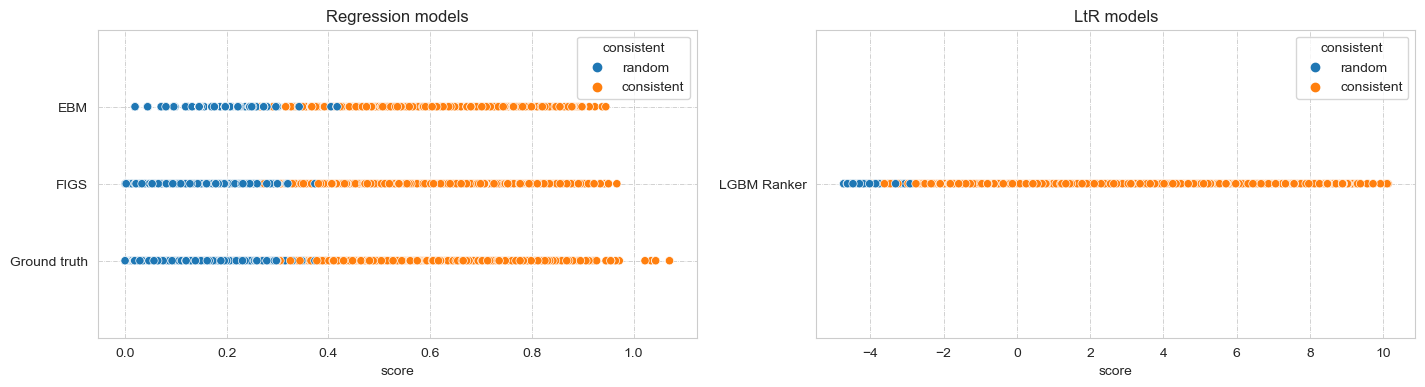

In [29]:
f, axs = plt.subplots(1,2, figsize=(17,4))

ax_ = np.ones_like(len(curricula))

sns.scatterplot(x="score", y="ax_", data=reg, hue="consistent", ax=axs[0])
axs[0].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs[0].set_yticks(np.arange(0,5,1), ["","Ground truth","FIGS","EBM",""])
axs[0].set_xlabel("score")
axs[0].set_ylabel("")
axs[0].set_title("Regression models")

sns.scatterplot(x="score", y="ax_", data=ltr, hue="consistent", ax=axs[1])
axs[1].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs[1].set_yticks(np.arange(0,3,1), ["","LGBM Ranker",""])
axs[1].set_xlabel("score")
axs[1].set_ylabel("")
axs[1].set_title("LtR models")

plt.show()

# Advanced Binning

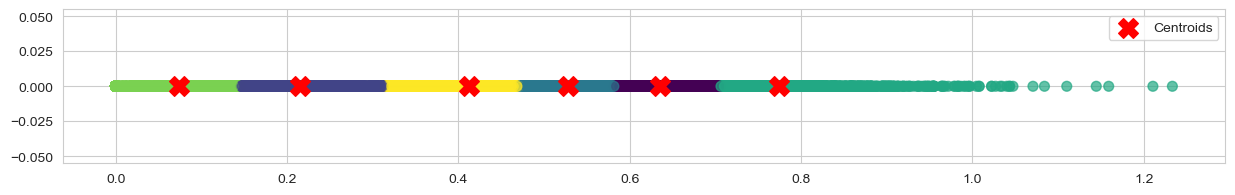

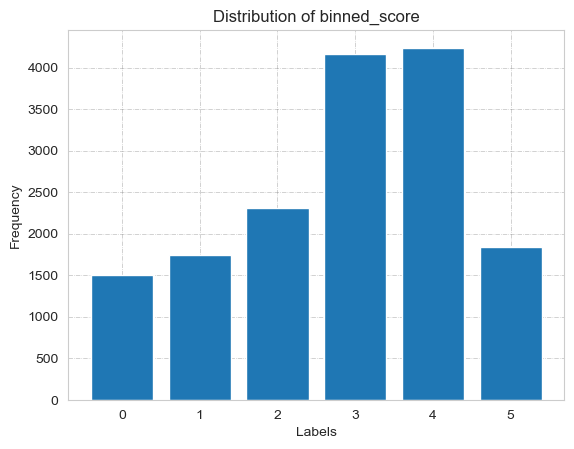

In [30]:
w_score = pd.read_csv("../outputs/scores/0_dataset.csv",usecols=[3]).to_numpy()

n_cluster = 6
kmeans = KMeans(n_clusters=n_cluster, random_state=42, n_init="auto")
kmeans.fit(w_score)


clusters = pd.DataFrame(kmeans.cluster_centers_,columns=["clus_pos"])
clusters["rank"] =clusters.clus_pos.rank().astype(int)-1
map_dict = clusters["rank"].to_dict()
labeled = list(map(lambda x: map_dict[x], kmeans.labels_))
distri_labels = [labeled.count(i) for i in range(max(labeled)+1)]
name_label = [*range(max(labeled)+1)]


plt.figure(figsize=(15,2))
plt.scatter(w_score, np.zeros_like(w_score), c=kmeans.labels_, cmap='viridis', s=50, alpha=0.7)
plt.scatter(kmeans.cluster_centers_, np.zeros_like(kmeans.cluster_centers_), c='red', marker='X', s=200, label='Centroids')
plt.legend()
plt.show()

plt.bar(name_label, distri_labels)
plt.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
plt.title('Distribution of binned_score')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()